In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
/kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
/kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
/kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
/kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav
/kaggle/input/cremad/AudioWAV/1027_DFA_DIS_XX.wav
/kaggle/input/cremad/AudioWAV/1032_IEO_HAP_HI.wav
/kaggle/input/cremad/AudioWAV/1023_TIE_SAD_XX.wav
/kaggle/input/cremad/AudioWAV/1041_TAI_DIS_XX.wav
/kaggle/input/cremad/AudioWAV/1004_WSI_SAD_XX.wav
/kaggle/input/cremad/AudioWAV/1030_DFA_HAP_XX.wav
/kaggle/input/cremad/AudioWAV/1037_WSI_NEU_XX.wav
/kaggle/input/cremad/AudioWAV/1006_IOM_FEA_XX.wav
/kaggle/input/cremad/AudioWAV/1053_IEO_HAP_LO.wav
/kaggle/input/cremad/AudioWAV/1076_IEO_FEA_HI.wav
/kaggle/input/cremad/AudioWAV/1055_TSI_SAD_XX.wav
/kaggle/input/cremad/AudioWAV/1019_TIE_DIS_XX.wav
/kaggle/input/cremad/AudioWAV/1014_TAI_ANG_XX.wav
/kaggle/input/cremad/AudioWAV/1087_TIE_DIS_XX.wav
/kaggle/input/cremad/AudioWAV/1009_IWW_DIS_XX.wav


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ejlok1/cremad")

print("Path to dataset files:", path)

In [2]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
from sklearn.utils import resample
from pathlib import Path

In [ ]:
pip install librosa matplotlib pandas

In [3]:
crema_path = '/kaggle/input/cremad/AudioWAV'
output_root = Path('./CREMA_augmented_outputs')
logmel_npy_dir = output_root / 'logmel_arrays_noised'
logmel_plot_dir = output_root / 'logmel_spectrograms_noised'
hist_dir = output_root / 'histograms'

In [4]:
FIXED_LENGTH_SEC = 3
WINDOW_SIZE = 0.025  
HOP_SIZE = 0.010   

In [5]:
for folder in [logmel_npy_dir, logmel_plot_dir, hist_dir]:
    folder.mkdir(parents=True, exist_ok=True)


def extract_emotion(filename):
    parts = filename.split('_')
    return parts[2] if len(parts) >= 4 else None

files = [f for f in os.listdir(crema_path) if f.endswith('.wav')]
data = pd.DataFrame({
    'filename': files,
    'emotion': [extract_emotion(f) for f in files]
})
data = data[data['emotion'].notna()].reset_index(drop=True)

print(f" Total audio files: {len(files)}")
print(f" Files with valid emotion labels: {len(data)}")
print(f" Emotion classes: {sorted(data['emotion'].unique())}")

 Total audio files: 7442
 Files with valid emotion labels: 7442
 Emotion classes: ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']


In [ ]:
emotion_plot_counter = {}
file_instance_counter = {}
failed_files = []

In [ ]:
def save_logmel_with_deltas_unique(filename, emotion):
    filepath = os.path.join(crema_path, filename)
    y, sr = librosa.load(filepath, sr=None)

    # Inject noise
    noise_amp = 0.035 * np.random.uniform() * np.amax(y)
    y += noise_amp * np.random.normal(size=y.shape[0])

    y = (y - np.mean(y)) / (np.std(y) + 1e-9)

    target_len = sr * FIXED_LENGTH_SEC
    y = y[:target_len] if len(y) > target_len else np.pad(y, (0, target_len - len(y)))

    n_fft = int(sr * WINDOW_SIZE)
    hop_length = int(sr * HOP_SIZE)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=64)
    logmel = librosa.power_to_db(mel, ref=np.max)
    delta = librosa.feature.delta(logmel)
    delta2 = librosa.feature.delta(logmel, order=2)
    combined = np.stack([logmel, delta, delta2], axis=0)  # shape: (3, 64, T)

    base_name = filename.replace('.wav', '')
    count = file_instance_counter.get(base_name, 0)
    file_instance_counter[base_name] = count + 1
    unique_name = f"{base_name}_{count}"

    # Save .npy file
    np.save(logmel_npy_dir / f"{unique_name}.npy", combined)

    if emotion_plot_counter.get(emotion, 0) < 3:
        plt.figure(figsize=(10, 3))
        librosa.display.specshow(logmel, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
        plt.title(f'Log-Mel Spectrogram: {emotion}')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(logmel_plot_dir / f"{unique_name}.png")
        plt.close()
        emotion_plot_counter[emotion] = emotion_plot_counter.get(emotion, 0) + 1

In [ ]:
for _, row in data.iterrows():
    try:
        save_logmel_with_deltas_unique(row['filename'], row['emotion'])
    except Exception as e:
        print(f"Failed: {row['filename']} | Reason: {e}")
        failed_files.append(row['filename'])

all_outputs = list(logmel_npy_dir.glob("*.npy"))
print("\n Processing Complete")
print(f"Files saved (including duplicates): {len(all_outputs)}")
print(f"Files failed: {len(failed_files)}")


 Processing Complete
Files saved (including duplicates): 7442
Files failed: 0


In [9]:
X, y = [], []

for f in os.listdir(logmel_npy_dir):
    if f.endswith(".npy"):
        array = np.load(os.path.join(logmel_npy_dir, f))
        if array.shape[2] < 300:
            pad = 300 - array.shape[2]
            array = np.pad(array, ((0, 0), (0, 0), (0, pad)))
        elif array.shape[2] > 300:
            array = array[:, :, :300]
        X.append(np.transpose(array, (2, 1, 0)))  # (time, mel, channels)
        y.append(extract_emotion(f))

In [10]:
X = np.array(X)
y = np.array(y)

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)

2025-04-27 11:33:33.006084: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745753613.260946      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745753613.342747      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

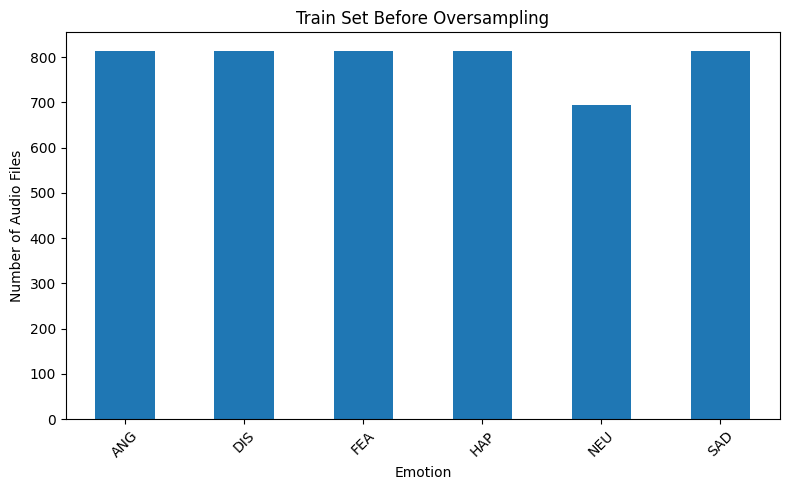

In [13]:
def plot_distribution(labels, title, filename):
    label_names = le.inverse_transform(np.unique(labels))
    counts = pd.Series(labels).value_counts().sort_index()
    counts.index = label_names

    plt.figure(figsize=(8, 5))
    counts.plot(kind='bar')
    plt.title(title)
    plt.xlabel("Emotion")
    plt.ylabel("Number of Audio Files")
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save the figure
    plt.savefig(hist_dir / filename)
    plt.show()
    plt.close()

plot_distribution(y_train_final, "Train Set Before Oversampling", "train_before_oversampling.png")

In [14]:
train_df = pd.DataFrame({'idx': np.arange(len(y_train_final)), 'label': y_train_final})
max_count = train_df['label'].value_counts().max()

balanced_indices = pd.concat([
    resample(group, replace=True, n_samples=max_count, random_state=42)
    for _, group in train_df.groupby('label')
])['idx'].values

X_train_balanced = X_train_final[balanced_indices]
y_train_balanced = y_train_final[balanced_indices]

In [15]:
y_train_cat = tf.keras.utils.to_categorical(y_train_balanced, num_classes=num_classes)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

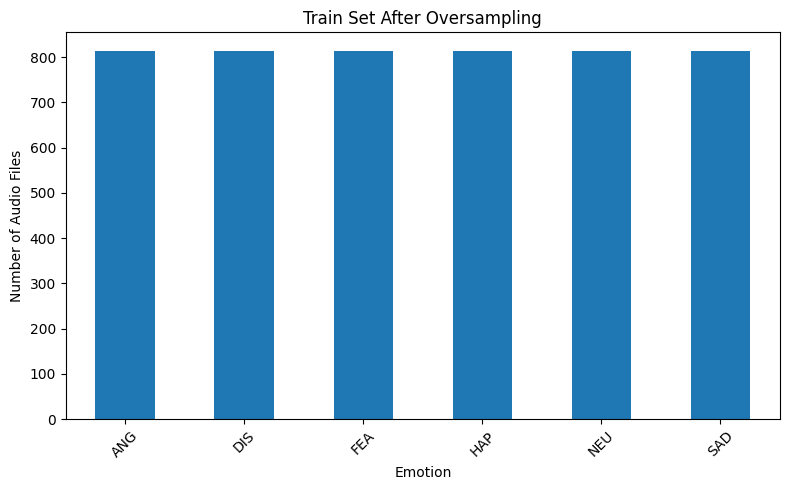

X_train_balanced: (4884, 300, 64, 3)
y_train_cat: (4884, 6)
X_val: (1191, 300, 64, 3)
y_val_cat: (1191, 6)
X_test: (1489, 300, 64, 3)
y_test_cat: (1489, 6)


In [16]:
plot_distribution(y_train_balanced, "Train Set After Oversampling", "train_after_oversampling.png")
print("X_train_balanced:", X_train_balanced.shape)
print("y_train_cat:", y_train_cat.shape)
print("X_val:", X_val.shape)
print("y_val_cat:", y_val_cat.shape)
print("X_test:", X_test.shape)
print("y_test_cat:", y_test_cat.shape)

In [ ]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout

def create_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(128, (5, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(1, 2))(x)
   
    x = layers.Conv2D(256, (5, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(1, 2))(x)

    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)  # (batch, time, features)
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.Dropout(0.3)(x)
    
    attention_output = MultiHeadAttention(num_heads=2, key_dim=128)(x, x)
    context = layers.GlobalAveragePooling1D()(attention_output)
    
    x = layers.Dense(64, activation='relu')(context)
    x = Dropout(0.3)(x) 
   
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    
    return tf.keras.Model(inputs, outputs)


In [18]:
model = create_model(X_train[0].shape, num_classes)
model.summary()

I0000 00:00:1745753644.720556      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745753644.721223      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 300, 64, 3)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 300, 64, 128)   │          5,888 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 300, 64, 128)   │            512 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 300, 32, 128)   │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 300, 32, 256)   │        491,776 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 300, 32, 256)   │          1,024 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 300, 16, 256)   │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 300, 4096)      │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 300, 128)       │      2,163,200 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 300, 128)       │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 300, 128)       │        131,968 │ dropout[0][0],         │
│ (MultiHeadAttention)      │                        │                │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 128)            │              0 │ multi_head_attention[… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │          8,256 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 6)              │            390 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,803,014 (10.69 MB)

 Trainable params: 2,802,246 (10.69 MB)

 Non-trainable params: 768 (3.00 KB)

In [19]:
# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.95,
    staircase=True
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=output_root / "saved_models/best_model.keras",
        save_best_only=True
    ),
    
    tf.keras.callbacks.TensorBoard(
        log_dir=output_root / "tensorboard_logs",
        histogram_freq=1
    )
]

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipvalue=5.0)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
history = model.fit(
    X_train_balanced, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/50


I0000 00:00:1745753765.197352     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


153/153 ━━━━━━━━━━━━━━━━━━━━ 76s 410ms/step - accuracy: 0.2845 - loss: 1.6582 - val_accuracy: 0.3736 - val_loss: 1.5092
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 63s 410ms/step - accuracy: 0.3951 - loss: 1.4887 - val_accuracy: 0.4131 - val_loss: 1.4443
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 64s 415ms/step - accuracy: 0.4365 - loss: 1.4265 - val_accuracy: 0.3871 - val_loss: 1.4819
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 64s 415ms/step - accuracy: 0.4650 - loss: 1.3383 - val_accuracy: 0.3627 - val_loss: 1.5824
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 64s 416ms/step - accuracy: 0.5058 - loss: 1.2776 - val_accuracy: 0.4383 - val_loss: 1.3663
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 64s 416ms/step - accuracy: 0.5542 - loss: 1.1716 - val_accuracy: 0.4307 - val_loss: 1.3561
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 64s 416ms/step - accuracy: 0.6100 - loss: 1.0498 - val_accuracy: 0.4391 - val_loss: 1.3862
Epoch 8/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 64s 415ms/step - accuracy: 0.6661 - loss: 0.9288 - val

38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step
\Classification Report:

              precision    recall  f1-score   support

         ANG       0.72      0.70      0.71       204
         DIS       0.48      0.52      0.50       203
         FEA       0.62      0.37      0.46       204
         HAP       0.51      0.50      0.51       203
         NEU       0.48      0.68      0.56       174
         SAD       0.56      0.56      0.56       203

    accuracy                           0.55      1191
   macro avg       0.56      0.56      0.55      1191
weighted avg       0.56      0.55      0.55      1191



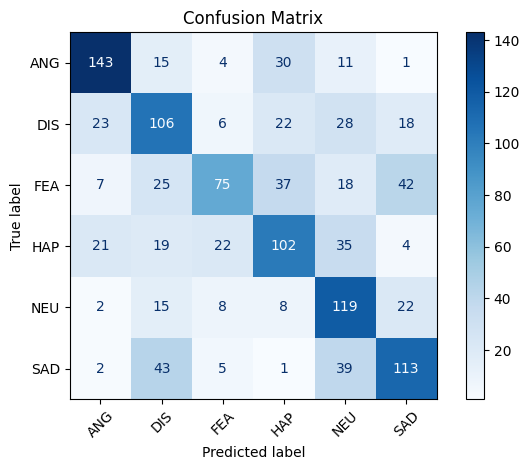

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_val_pred_probs = model.predict(X_val)
y_val_pred_labels = np.argmax(y_val_pred_probs, axis=1)

y_val_true_labels = y_val

emotion_names = le.classes_

print("\Classification Report:\n")
print(classification_report(y_val_true_labels, y_val_pred_labels, target_names=emotion_names))

cm_val = confusion_matrix(y_val_true_labels, y_val_pred_labels)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=emotion_names)
disp_val.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test_cat, verbose=1)

print(f"Test Accuracy: {accuracy * 100:.2f}%")

47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.5588 - loss: 1.1761
Test Accuracy: 55.20%


In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np

# Predict on test set
y_test_pred_probs = model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred_probs, axis=1)
y_test_true_labels = y_test

# Inverse transform to get original labels
class_names = le.classes_

# Class-wise accuracy
print("\nPer-Class Test Accuracy:\n")
for class_idx, class_name in enumerate(class_names):
    idxs = np.where(y_test_true_labels == class_idx)[0]
    correct = np.sum(y_test_pred_labels[idxs] == class_idx)
    total = len(idxs)
    acc = correct / total if total > 0 else 0.0
    print(f"{class_name}: {acc:.4f} ({correct}/{total})")

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step

Per-Class Test Accuracy:

ANG: 0.6024 (153/254)
DIS: 0.5787 (147/254)
FEA: 0.3150 (80/254)
HAP: 0.5255 (134/255)
NEU: 0.7064 (154/218)
SAD: 0.6063 (154/254)


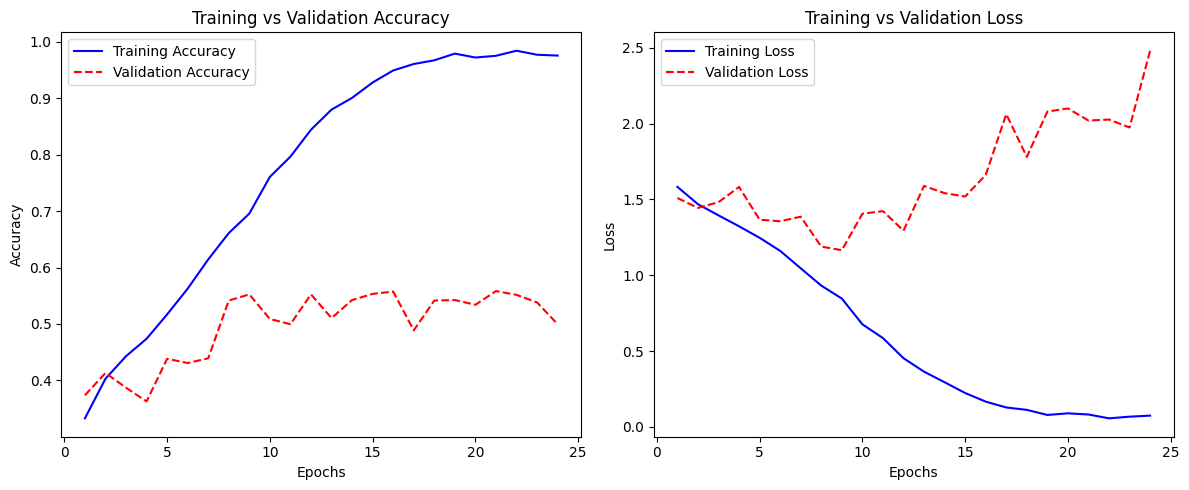

In [24]:
import matplotlib.pyplot as plt

def plot_training_history(history, save_path=None):
    """
    Plots training and validation accuracy and loss curves.

    Parameters:
    - history: Keras History object
    - save_path: Optional path to save the figure
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    plt.show()

# Usage
plot_training_history(history, save_path=output_root/"accuracy_loss_plot")

In [25]:
import shutil
shutil.make_archive("/kaggle/working/CREMA_augmented_outputs", 'zip', "/kaggle/working")

'/kaggle/working/CREMA_augmented_outputs.zip'